In [1]:
using PauliPropagation
using Random
using Optim
using Plots
#Random.seed!(43)
using ReverseDiff: GradientTape, gradient!, compile
using LinearAlgebra
using StatsBase

## CDR (Clifford Data Regression) 
This is the main idea:
(https://arxiv.org/abs/2005.10189)

- We create a training set consisting of classical "exact" expectation values using PP and noisy expectation values using a noisy simulator or a quantum device.
- Then we fit a linear ansatz (and later a more complex noise model) in order to predict the correction to mitigate the errors on our noisy observables.
- To create the training set, we use MCMC sampling.
- Question: Could we use the noisy circuits within `PauliPropagation.jl` to generate our noisy expectation values? -Yes we can, we can model our noise using gates, in the case of global noise, the linear fit will give us the exact correction. We can also apply local noise and try to find a better model (Lindblad) to correct for this.

In the first step we implement the system they use in the paper, but replace the MPS with PP.


### Functions for QAOA on Ising spin chain
We take the same setup as in the paper:
- TFIM with obc and even number of qubits
- QAOA (Quantum Alternating Operator Ansatz) circuit
- Parameter assignment function (each RZZ and each RZ layer has the same parameters)

In [2]:
#QAOA circuit (Fig 10)
function tfimqaoacircuit(nqubits::Integer, nlayers::Integer; topology=nothing)
    circuit::Vector{Gate} = []

    if isnothing(topology)
        topology = bricklayertopology(nqubits;periodic=false) #chain with obc
    end

    for i in 1:nlayers
        rzzlayer!(circuit, topology)
        for qubit in 1:nqubits
            push!(circuit, CliffordGate(:S, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2)) # Fig 10: P=R_X(π/2)
            push!(circuit, PauliRotation(:Z, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2))
            push!(circuit, CliffordGate(:S, qubit))

        end
    end
    return circuit
end

tfimqaoacircuit (generic function with 1 method)

In [3]:
#grouped assignment of the params for QAOA circuit
function assign_qaoa_parameters(circuit, nqubits::Integer, nlayers::Integer)
    
    rzz_indices = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    rz_indices = getparameterindices(circuit, PauliRotation, [:Z])

    #group sizes
    Q_minus_1 = (nqubits - 1) * nlayers  # RZZ parameters
    Q = nqubits * nlayers                # RZ parameters

    #group the random values according to circuit layout
    thetas = zeros(maximum(vcat(rzz_indices, rz_indices)))
    thetas[rzz_indices] .= repeat(randn(nlayers), inner=(Q_minus_1 ÷ nlayers))
    thetas[rz_indices] .= repeat(randn(nlayers), inner=(Q ÷ nlayers))

    return thetas
end

assign_qaoa_parameters (generic function with 1 method)

### Initialize circuit
- initial parameters are set
- define truncations dpending on the method of gradient computation
- for `ReverseDiff`, better to use `max_weight` (number of non-Id in string), `max_freq`, and `max_sins`(number of sins - as in SPD) (see notebook 8)
- define H within loss function

In [4]:
const nq = 4 #we set const for global vars in fcts to opt performance
const nl = 2 #number of layers/rounds
const topology = bricklayertopology(nq;periodic=false) #chain with obc  
const g = 2 #paramagnetic phase

2

In [5]:
const circuit = tfimqaoacircuit(nq, nl; topology=topology)
nparams = countparameters(circuit)
println("Number of parameters: ", nparams) 
#generate random parameters
thetas_init = assign_qaoa_parameters(circuit, nq, nl)
println("Parameters: ", thetas_init)

Number of parameters: 14
Parameters: [-0.17480467989177167, -0.17480467989177167, -0.17480467989177167, -0.400791928851502, -0.400791928851502, -0.400791928851502, -0.400791928851502, 1.1269435626072213, 1.1269435626072213, 1.1269435626072213, -0.5094857492239786, -0.5094857492239786, -0.5094857492239786, -0.5094857492239786]


In [6]:
#define the truncations
const max_freq = 30
const max_weight = 5 #number of non-Id Paulis in string

5

### Loss function for TFIM and classical optimization

In [7]:
# function lossfunction(thetas)
#     type_of_coeff = eltype(thetas)
#     H = PauliSum(nq, type_of_coeff)
#     for qind in 1:nq
#         add!(H, :X, qind, type_of_coeff(-g))
#     end
#     for pair in topology
#         add!(H, [:Z, :Z], collect(pair), type_of_coeff(1.0))
#     end
    
#     wrapped_H = wrapcoefficients(H, PauliFreqTracker) #wrap to keep track of path splitting

#     # We also need to run the in-place version with `!`, because by default we copy the Pauli sum
#     wrapped_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
#     return overlapwithplus(wrapped_H)
# end

function fulllossfunction(thetas, circuit, topology, nq; max_freq=Inf, max_weight=Inf)
    type_of_coeff = eltype(thetas)
    H = PauliSum(nq, type_of_coeff)
    for qind in 1:nq
        add!(H, :X, qind, type_of_coeff(-g))
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), type_of_coeff(1.0))
    end
    
    wrapped_H = wrapcoefficients(H, PauliFreqTracker) #wrap to keep track of path splitting

    # We also need to run the in-place version with `!`, because by default we copy the Pauli sum
    wrapped_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);

    # MR: Shouldn't this be plus for QAOA?
    return overlapwithplus(wrapped_H)
end

lossfunction = let const_circuit=circuit, const_topology=topology, const_nq=nq, const_max_freq=max_freq,  const_max_weight=max_weight
    # these are now all captured variables with known types and we return a function that only takes thetas
    # See also "closures"
    thetas -> fulllossfunction(thetas, const_circuit, const_topology, const_nq; max_freq=const_max_freq, max_weight=const_max_weight)
end


lossfunction (generic function with 1 method)

In [8]:
@time lossfunction(thetas_init) #check

  1.004631 seconds (1.80 M allocations: 89.464 MiB, 1.72% gc time, 99.97% compilation time)


-4.516893652626697

In [9]:
### This is following an ReverseDiff.jl example

# some inputs and work buffer to play around with
# grad_array_compiled = similar(thetas_init);

# # pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements

# const simulation_tape = GradientTape(lossfunction, thetas_init)
# const compiled_simulation_tape = compile(simulation_tape)
#graph for the chain rule is computed only once! (const)

# first evaluation compiles and is slower
#@time gradient!(grad_array_compiled, compiled_simulation_tape, thetas)
# second evaluation
#@time gradient!(grad_array_compiled, compiled_simulation_tape, thetas);

typename(ReverseDiff.CompiledTape)(lossfunction)

In [10]:
function constrain_params(thetas, repartition)
    for r in repartition
        for q in r
            thetas[q] = thetas[r[1]]
        end
    end
end

constrain_params (generic function with 1 method)

-2.089329457006629


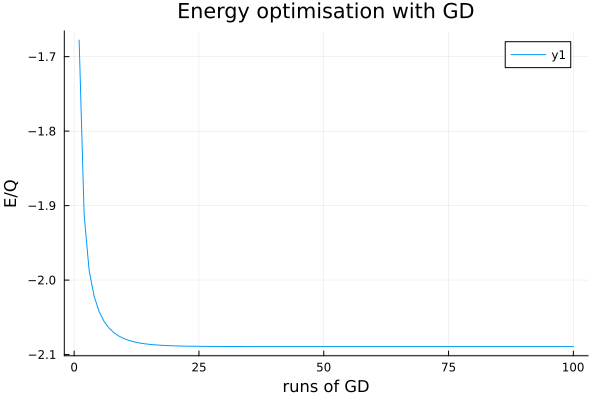

In [11]:
function gd(thetas_init, repartition, eta=0.1)
    # some inputs and work buffer to play around with
    grad_array_compiled = similar(thetas_init);
    
    # pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements
    
    simulation_tape = GradientTape(lossfunction, thetas_init)
    compiled_simulation_tape = compile(simulation_tape)

    opt_energy_gd = []
    thetas = thetas_init
    for i in 1:100 # steps
        gradient!(grad_array_compiled, simulation_tape, thetas)
        thetas .-= eta * grad_array_compiled
        constrain_params(thetas, repartition)
        opt_energy_gd = push!(opt_energy_gd, lossfunction(thetas)/nq)
    end

    return thetas, opt_energy_gd
end

In [ ]:
# gradient descent
# eta = 0.1
# opt_energy_gd = []
# thetas = thetas_init
# for i in 1:100 # steps
#     gradient!(grad_array_compiled, simulation_tape, thetas)
#     thetas .-= eta * grad_array_compiled
#     constrain_params(thetas, [[1,2, 3], [4, 5, 6, 7], [8, 9, 10], [11, 12, 13, 14]])
#     opt_energy_gd = push!(opt_energy_gd, lossfunction(thetas)/nq)
# end
#println(thetas) #Why do the first few stay the same, while the end is strongly modified? Is this sth systematic?
thetas, opt_energy_gd = gd(thetas_init, [[1,2, 3], [4, 5, 6, 7], [8, 9, 10], [11, 12, 13, 14]])
println(lossfunction(thetas)/nq)
plot(opt_energy_gd)

plot!(title = "Energy optimisation with GD", xlabel = "runs of GD", ylabel = "E/Q")

In [12]:
 #ADAM (this is suboptimal because we recalculate the gradients)
# thetas = thetas_init
# opt_energy_adam = []

# opt_result = Optim.optimize(lossfunction, thetas, Adam(), Optim.Options(iterations=1000))
# thetas .= Optim.minimizer(opt_result)

# #println(thetas)  # Check the final optimized parameters
# println(lossfunction(thetas)/nq)  # Check the final optimized energy (similar to GD)

### Comments so far:

- We have (2Q-1) non-Cliffords in the circuit so for Q=16 qubits, we have N=31 non-Cliffords already (this is quite high for a cl. simulation, state of the art is N<80 and Piotr used MPS with up to N=35)
- When we initialise the parameters, they are fixed to have the same values in every RZZ and RZ layer, but later this changes during optimization. How can we keep this constraint during the optimization? (We need the constraint so it could be implementable as a "real" circuit, right?)
- We get the warning `WARNING: redefinition of constant Main.simulation_tape.`, should we keep doing this like in the example notebooks?

## Generating the set of test states - Isolated functions
- generate a set of classically efficiently simulable states $S_{\psi} =\{|\phi_i>\}$
- the initial state `initialize_mcmc_circuit()` is chosen by finding a near-Clifford circuit wrt the target circuit `tfimqaoacircuit()`
- update steps: randomly pick $n_p$ pairs of the circuits RZ rotations (RZZ are also just RZ rotations with CNOT before and after)
- in each pair keep one gate as non-Clifford and replace the other by $S^n$, where $S$ is the $\pi/2$ rotation gate, take an integer power $n$ (which we choose by sampling according to eq. 14)
- this "pair mechanism" makes sure we don't replace too many gates with Clifford gates, which would lead to a larger distance from the target state $\ket{\psi}$.

### Initial circuit for MCMC with less non-Clifford gates 

In [13]:
function initialize_mcmc_circuit(circuit, nqubits::Integer, nlayers::Integer)
    # Choose nq*nl/2 random Pauli rotations to replace with Clifford R_Z(k_p π/2) gates.
    # The replacements are random for the whole circuit and don't repeat for each layer.

    # Get indices of Pauli rotations
    z_rot_indices = [i for i in eachindex(circuit) if isa(circuit[i], PauliRotation)]

    num_to_replace = div(nqubits * nlayers, 2)
    Random.shuffle!(z_rot_indices)
    indices_replaced = z_rot_indices[1:num_to_replace]
    #println("Indices to replace: ", indices_to_replace)

    # Extract qubit indices for gates to be replaced
    qubits = [circuit[i].qinds for i in indices_replaced]
    #println("Qubits involved: ", qubits)

    # Create a modified circuit
    new_circuit = copy(circuit)

    # Replace selected R_Z rotations with Clifford R_Z(k_p π/2)
    for (j, i) in enumerate(indices_replaced)
        k_p = rand(0:3)  ### Randomly select k_p from {0,1,2,3} ( NO CLEAR INDICATION in the paper)
        if length(qubits[j]) == 1
            new_circuit[i] = PauliRotation(:Z, qubits[j], k_p * π/2)  # Replace with Clifford rotation
        else
            new_circuit[i] = PauliRotation([:Z, :Z], qubits[j], k_p * π/2)  # Replace with Clifford rotation
        end
    end

    return new_circuit, indices_replaced
end

initialize_mcmc_circuit (generic function with 1 method)

In [14]:
init_circuit, indices_replaced = initialize_mcmc_circuit(circuit, nq, nl) #check
init_circuit
indices_replaced
current_cicuit = deepcopy(init_circuit)
current_replaced_indices = deepcopy(indices_replaced)   

4-element Vector{Int64}:
 39
 26
 44
  3

In [15]:
#test the init function:
println(circuit)
println(init_circuit)   

Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), PauliRotation([:Z], [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), PauliRotation([:Z], [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), CliffordGate(:S, [2]), CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), PauliRotation([:Z], [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4]), PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), p

### Proposal function with random sampling (TO BE REPLACED with eq 14)

In [16]:
# Define the function to apply circuit updates
function proposal_random_tfimqaoacircuit(target_circuit::Vector{Gate},current_circuit::Vector{Gate},current_replaced_indices::Vector{Int},np::Integer=2)    
    # Identify all Pauli Z rotations in the circuit (includes RZZ) (Pauli Z are only the non-Cifford's here)
    proposal_circuit = deepcopy(current_circuit)
    z_rot_indices = [i for i in eachindex(proposal_circuit) if isa(proposal_circuit[i], PauliRotation)]

    println("Z rotation indices (Non-Cliffords): ", z_rot_indices)
    println("Indices replaced (Frozen Z rotations (Cliffords)): ", current_replaced_indices)  
    # Ensure we have enough pairs
    if length(current_replaced_indices) < np
        error("Not enough frozen Pauli rotations in the initialized MCMC circuit to select the value of pairs.")
    end

    # Shuffle and select n_p pairs
    Random.shuffle!(z_rot_indices)
    Random.shuffle!(current_replaced_indices)
    selected_pairs = [(z_rot_indices[i], current_replaced_indices[i]) for i in 1:np] #
    
    println("Selected pairs of Cliff. and non-Clifford: ", selected_pairs) 
    #println("Circuit before replacement: ", proposal_circuit)

    #choose left element of each pair and replace with Clifford gate S^n,sample n
    for (i, j) in selected_pairs
        qubits = proposal_circuit[i].qinds
        #println("Qubits involved: ", qubits)
        
        k_p = rand(0:3) # SEE BELOW: we need to sample from eq 14
        if length(qubits) == 1
            proposal_circuit[i] = PauliRotation(:Z, qubits, k_p * π/2)  # Replace with Clifford rotation
        else
            proposal_circuit[i] = PauliRotation([:Z, :Z], qubits, k_p * π/2)  # Replace with Clifford rotation
        end
    end
    #println("Circuit after first replacement: ", proposal_circuit)


    #then reset the right element (Clifford, FrozenGate[PauliRotation]]) to the one of the target circuit
    for (i, j) in selected_pairs 
        qubits = proposal_circuit[j].gate.qinds
        proposal_circuit[j] = target_circuit[j] 
    end
    #println("Circuit after second replacement: ", proposal_circuit)
    ##TODO: 
    #set new current_replaced_indices (non-replaced ones and the new ones)
    #delete the ( , j) items from current_replaced_indices, add the (i, ) items
    updated_replaced_indices = setdiff(current_replaced_indices, [j for (_, j) in selected_pairs])
    append!(updated_replaced_indices, [i for (i, _) in selected_pairs])

    return proposal_circuit, updated_replaced_indices
end

proposal_random_tfimqaoacircuit (generic function with 2 methods)

### Isolated sampling function

In [17]:
    function compute_distance(alpha, n)
        Pauli_z = [1 0; 0 -1]
        S_n = exp(-im * n * π / 2 * Pauli_z)
        println("S_n: ", S_n)
        Rz_alpha = exp(-im * alpha * Pauli_z/2)
        println("Rz_alpha: ", Rz_alpha)
        return LinearAlgebra.norm(Rz_alpha - S_n)
    end
    
    # Define probability distribution function
    function sample_kn(alpha)
        sigma = 0.5
        n_vals =LinRange(0,7,8) # limit n values (they repeat after 2 pi)
        distances = [compute_distance(alpha, n) for n in n_vals]
        println("Distances: ", distances)
        weights = exp.(-distances.^2 ./ sigma^2)
        println("Weights: ", weights)
        probs = ProbabilityWeights(weights ./ sum(weights)) 
        println("Probs",probs) # Normalize probabilities
        return StatsBase.sample(n_vals,probs,1)  # Sample from the distribution (using StatsBase)
    end

sample_kn (generic function with 1 method)

In [18]:
println("Initial circuit: ", init_circuit)


Initial circuit: Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), FrozenGate(PauliRotation([:Z, :Z], [2, 3]), parameter = 4.71), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), PauliRotation([:Z], [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), PauliRotation([:Z], [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), CliffordGate(:S, [2]), CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), PauliRotation([:Z], [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4]), PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), FrozenGate(PauliRotation([:Z, :Z], [2, 3]), par

In [19]:
proposal_circuit, updated_replaced_indices = proposal_random_tfimqaoacircuit(circuit, init_circuit, indices_replaced, 2) #check
print("Updated indices: ", updated_replaced_indices)

prop_2, update_2 = proposal_random_tfimqaoacircuit(circuit, proposal_circuit, updated_replaced_indices, 2) 
print("Updated indices: ", update_2)

Z rotation indices (Non-Cliffords): [1, 2, 6, 11, 16, 21, 24, 25, 29, 34]
Indices replaced (Frozen Z rotations (Cliffords)): [39, 26, 44, 3]
Selected pairs of Cliff. and non-Clifford: [(21, 44), (1, 39)]
Updated indices: [26, 3, 21, 1]Z rotation indices (Non-Cliffords): [2, 6, 11, 16, 24, 25, 29, 34, 39, 44]
Indices replaced (Frozen Z rotations (Cliffords)): [26, 3, 21, 1]
Selected pairs of Cliff. and non-Clifford: [(24, 1), (39, 3)]
Updated indices: [26, 21, 24, 39]

In [20]:
#short check that our replacements FrozenGates[PauliRotation[]] are not PauliRotations anymore
println(init_circuit[11] isa PauliRotation)
println(init_circuit[11] isa FrozenGate)

true
false


###  Sample prob dist. eq 14
- FIXED: We don't know what $\alpha$ in $R_z(\alpha)$ should be here  (eq. 14) , so its set to a fixed value for now.

In [21]:
# Define the function to apply circuit updates
function proposal_tfimqaoacircuit(target_circuit::Vector{Gate},current_circuit::Vector{Gate},current_replaced_indices::Vector{Int},thetas::Vector{Float64},repartition::Vector{Vector{Int}},np::Integer=2)    
    # Identify all Pauli Z rotations in the circuit (includes RZZ) (Pauli Z are only the non-Cifford's here)
    proposal_circuit = deepcopy(current_circuit)
    z_rot_indices = [i for i in eachindex(proposal_circuit) if isa(proposal_circuit[i], PauliRotation)]

    println("Z rotation indices (Non-Cliffords): ", z_rot_indices)
    println("Indices replaced (Frozen Z rotations (Cliffords)): ", current_replaced_indices)  
    # Ensure we have enough pairs
    if length(current_replaced_indices) < np
        error("Not enough frozen Pauli rotations in the initialized MCMC circuit to select the value of pairs.")
    end

    # Shuffle and select n_p pairs
    Random.shuffle!(z_rot_indices)
    Random.shuffle!(current_replaced_indices)
    selected_pairs = [(z_rot_indices[i], current_replaced_indices[i]) for i in 1:np] #
    
    println("Selected pairs of Cliff. and non-Clifford: ", selected_pairs) 
    #println("Circuit before replacement: ", proposal_circuit)

    function compute_distance(alpha, n)
        Pauli_z = [1 0; 0 -1]
        S_n = exp(-im * n * π / 2 * Pauli_z)
        #println("S_n: ", S_n)
        Rz_alpha = exp(-im * alpha * Pauli_z/2)
        #println("Rz_alpha: ", Rz_alpha)
        return LinearAlgebra.norm(Rz_alpha - S_n)
    end
    
    # Define probability distribution function
    function sample_kn(alpha)
        sigma = 0.5
        n_vals =LinRange(0,7,8) # limit n values (they repeat after 2 pi)
        distances = [compute_distance(alpha, n) for n in n_vals]
        #println("Distances: ", distances)
        weights = exp.(-distances.^2 ./ sigma^2)
        #println("Weights: ", weights)
        probs = ProbabilityWeights(weights ./ sum(weights)) 
        #println("Probs",probs) # Normalize probabilities
        return first(StatsBase.sample(n_vals,probs,1))  # Sample from the distribution (using StatsBase)
    end

    function get_alpha(qubits, thetas, repartition)
        # allows to break from nested loops
        function find_alpha()
            found = false
            alpha = 0
            for k in qubits
                for (i, r) in enumerate(repartition)
                    for q in r
                        if q==k
                            alpha = thetas[i]
                            found = true
                            return alpha, found
                        end
                    end
                end
            end
            return alpha, found
        end

        alpha, found = find_alpha()
        if !found
            throw("qubits $qubits not found in repartition")
        else
            return alpha
        end
    end

    #choose left element of each pair and replace with Clifford gate S^n,sample n
    for (i, j) in selected_pairs
        qubits = proposal_circuit[i].qinds
        #println("Qubits involved: ", qubits)
        alpha = get_alpha(qubits, thetas, repartition)
        
        k_p = sample_kn(alpha)
        # print(k_p) # SEE BELOW: we need to sample from eq 14
        if length(qubits) == 1
            proposal_circuit[i] = PauliRotation(:Z, qubits, k_p * π/2)  # Replace with Clifford rotation
        else
            proposal_circuit[i] = PauliRotation([:Z, :Z], qubits, k_p * π/2)  # Replace with Clifford rotation
        end
    end
    #println("Circuit after first replacement: ", proposal_circuit)


    #then reset the right element (Clifford, FrozenGate[PauliRotation]]) to the one of the target circuit
    for (i, j) in selected_pairs 
        qubits = proposal_circuit[j].gate.qinds
        proposal_circuit[j] = target_circuit[j] 
    end
    #println("Circuit after second replacement: ", proposal_circuit)
    
    #update the replaced indices
    updated_replaced_indices = setdiff(current_replaced_indices, [j for (_, j) in selected_pairs])
    append!(updated_replaced_indices, [i for (i, _) in selected_pairs])

    return proposal_circuit, updated_replaced_indices
end

proposal_tfimqaoacircuit (generic function with 2 methods)

In [22]:
repartition = [[1,2, 3], [4, 5, 6, 7], [8, 9, 10], [11, 12, 13, 14]]
proposal_circuit, ind_repl = proposal_tfimqaoacircuit(circuit, init_circuit, indices_replaced, thetas, repartition, 2) #check this works iteratively
new_proposal, new_ind_repl = proposal_tfimqaoacircuit(circuit, proposal_circuit, ind_repl, thetas, repartition, 2)
println("New proposal 1: ", new_proposal) #we need to name a variable to keep the new proposal
new_proposal_2, ind_repl_2 = proposal_tfimqaoacircuit(circuit, new_proposal, new_ind_repl, thetas, repartition, 2)
println("New proposal 2: ", new_proposal_2) 

Z rotation indices (Non-Cliffords): [1, 2, 6, 11, 16, 21, 24, 25, 29, 34]
Indices replaced (Frozen Z rotations (Cliffords)): [44, 39, 26, 3]
Selected pairs of Cliff. and non-Clifford: [(16, 44), (2, 3)]
4.00.0Z rotation indices (Non-Cliffords): [1, 3, 6, 11, 21, 24, 25, 29, 34, 44]
Indices replaced (Frozen Z rotations (Cliffords)): [39, 26, 16, 2]
Selected pairs of Cliff. and non-Clifford: [(29, 2), (6, 39)]
4.04.0New proposal 1: Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), FrozenGate(PauliRotation([:Z], [1]), parameter = 6.28), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), PauliRotation([:Z], [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), CliffordGate(:S, [2]), CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), para

## Next steps: 
JERG:
- DONE: constrain the parameters in loss function (dict or as Manuel suggested)
- DONE: closure thing (code loss function, add closure outside to optimize) , so far no exact position of this closure
- find the parameter $\alpha$ (optimised $\alpha$ from target circuit of that exact gate)  for the proposal function (sample n) (page 7 eq 14, Appendix B of paper)

Yulia:
- define the MH algorithm (propose until a sample is accepted, then from this accepted sample start proposing again)
- merge everything into one MCMC function

### Under construction: Merged MCMC function
- list with acceptance rate
- n_sweeps to decorrelate
- burn-in time (additional percent)

In [ ]:
function MCMC(target_circuit::Vector{Gate},current_circuit::Vector{Gate},nqubits::Integer,nlayers::Integer,current_replaced_indices::Vector{Int},num_samples::Integer = 1000,burn_in_per =0.2,n_sweeps::Integer =1, np::Integer=2, x_sigma::Float64=0.5,x_0::Float64 =-2.1)
    #init the MCMC
    initial_circuit, initial_replaced_indices = initialize_mcmc_circuit(target_circuit, nq, nl)
    n_accepted = 0 
    rounded_burn_in = Int(round(burn_in_per * num_samples)) 

    current_circuit = deepcopy(initial_circuit)
    current_replaced_indices = deepcopy(initial_replaced_indices)
    #add burn-in time

    acceptance_rates = []
    acc_samples = []
    exact_energies = []
    for i in range(1,Int(num_samples+rounded_burn_in))

        proposal_circuit, updated_replaced_indices = proposal_tfimqaoacircuit(target_circuit, current_circuit, current_replaced_indices, np)
        
        #calc x_exact normalised (loss fct and gd)
        
        #acceptance ratio
        acc_ratio = min(1,exp(-x_exact-x_0)**2/exp(x_sigma)**2)

        if rand() < acc_ratio
            current_circuit = deepcopy(proposal_circuit)
            current_replaced_indices = deepcopy(updated_replaced_indices)
            n_accepted += 1
        end
        acceptance_rate = n_accepted/i

        #only record after burn-in
        #only record every n_th sample (n_sweeps)
        if i > rounded_burn_in
            if i%n_sweeps == 0
                push!(acc_samples, current_circuit)
                push!(exact_energies, x_exact)
                push!(acceptance_rates,acceptance_rate)
        end

        
    end

    return acc_samples,exact_energies,acceptance_rates
end



MCMC (generic function with 2 methods)

In [ ]:
function plot_MCMC(acc_samples,exact_energies,acceptance_rates)
    #plot the acceptance rates
    plot(acceptance_rates)
    plot!(title = "Acceptance rates", xlabel = "runs of MCMC", ylabel = "Acceptance rate")

    #plot the energy (not correlated if n_sweeps large enough)
    plot(exact_energies)
    plot!(title = "Energy optimisation with MCMC", xlabel = "runs of MCMC", ylabel = "E/Q",)
end

In [28]:
MCMC(circuit, init_circuit, nq, nl, indices_replaced, 2) #check

Z rotation indices (Non-Cliffords): [1, 2, 6, 11, 16, 21, 24, 25, 29, 34]
Indices replaced (Frozen Z rotations (Cliffords)): [26, 39, 44, 3]
Selected pairs of Cliff. and non-Clifford: [(29, 26), (2, 39)]
0.00.0Z rotation indices (Non-Cliffords): [1, 2, 6, 11, 16, 21, 24, 25, 29, 34]
Indices replaced (Frozen Z rotations (Cliffords)): [26, 39, 44, 3]
Selected pairs of Cliff. and non-Clifford: [(34, 39), (6, 3)]
4.04.0

(Gate[PauliRotation([:Z, :Z], [1, 2]), FrozenGate(PauliRotation([:Z, :Z], [3, 4]), parameter = 3.14), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), FrozenGate(PauliRotation([:Z], [1]), parameter = 3.14), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57)  …  CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), FrozenGate(PauliRotation([:Z], [4]), parameter = 3.14), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4])], [6, 25, 44, 2])

In [25]:
proposal_circuit, ind_repl = proposal_tfimqaoacircuit(circuit, init_circuit, indices_replaced, 2) #check this works iteratively

Z rotation indices (Non-Cliffords): [1, 2, 6, 11, 16, 21, 24, 25, 29, 34]
Indices replaced (Frozen Z rotations (Cliffords)): [39, 44, 3, 26]
Selected pairs of Cliff. and non-Clifford: [(29, 26), (6, 39)]
0.00.0

(Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), FrozenGate(PauliRotation([:Z, :Z], [2, 3]), parameter = 4.71), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), FrozenGate(PauliRotation([:Z], [1]), parameter = 0.0), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57)  …  CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), FrozenGate(PauliRotation([:Z], [4]), parameter = 1.57), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4])], [44, 3, 29, 6])

In [26]:
new_proposal, new_ind_repl = proposal_tfimqaoacircuit(circuit, proposal_circuit, ind_repl, 2)

Z rotation indices (Non-Cliffords): [1, 2, 11, 16, 21, 24, 25, 26, 34, 39]
Indices replaced (Frozen Z rotations (Cliffords)): [44, 3, 29, 6]
Selected pairs of Cliff. and non-Clifford: [(25, 29), (34, 3)]
4.04.0

(Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), FrozenGate(PauliRotation([:Z], [1]), parameter = 0.0), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57)  …  CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), FrozenGate(PauliRotation([:Z], [4]), parameter = 1.57), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4])], [44, 6, 25, 34])